In [59]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
from scipy.stats import qmc
from scipy.stats import norm, ttest_ind
import os

In [60]:
#Jonas
SAVE_DIR = 'media/'
os.makedirs(SAVE_DIR, exist_ok=True)
X_LIM = (-2, 0.75)
Y_LIM = (-1.25, 1.25)

In [61]:
# Checking if a point is part of the mandelbrot set Jonas
@jit(nopython=True)
def mandelbrot(z, max_iter):
    c = z
    for i in range(max_iter):
        if np.abs(z) > 2:
            return i
        z = z*z + c
    return max_iter

# Raymond
def bootstrap_confidence_interval(data, num_bootstrap_iters=1000, confidence_level=0.95):
    bootstrap_means = np.empty(num_bootstrap_iters)
    for i in range(num_bootstrap_iters):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return np.percentile(bootstrap_means, [(1 - confidence_level) / 2 * 100, (1 + confidence_level) / 2 * 100])

# Raymond
def hypothesis_testing(data1, data2, alpha=0.05):
    stat, p_value = stats.ttest_ind(data1, data2)
    if p_value < alpha:
        print("Reject the null hypothesis, indicating a significant difference between the two samples.")
    else:
        print("Fail to reject the null hypothesis, indicating no significant difference between the two samples.")
    return stat, p_value

# Utility to calculate statistics of generated set, written by Jonas for question 1 and extended by Raymond for question 2 and 3.
def mandelbrot_statistics(c_points, counts, method, previous_stats=None, tolerance=0.01):
    total_area = abs(X_LIM[0] - X_LIM[1]) * abs(Y_LIM[0] - Y_LIM[1])
    max_iter = np.max(counts)
    mandelbrot_ratio = np.count_nonzero(counts == max_iter) / counts.size
    mandelbrot_area = total_area * mandelbrot_ratio
    inside = counts == max_iter
    area_samples = inside / (counts.size / total_area)
    sample_mean = np.mean(area_samples)
    sample_std = np.std(area_samples, ddof=1)  # ddof=1 for sample std. dev.
    confidence_interval = norm.interval(0.95, loc=sample_mean, scale=sample_std / np.sqrt(area_samples.size))

    has_converged = False
    if previous_stats:
        mean_change = abs(previous_stats['mean'] - sample_mean)
        std_change = abs(previous_stats['std'] - sample_std)
        if mean_change < tolerance and std_change < tolerance:
            has_converged = True
    
    stats = {
        'area': mandelbrot_area,
        'mean': sample_mean,
        'std': sample_std,
        'conf_int': confidence_interval,
        'has_converged': has_converged
    }
    
    # Print only if there's a significant change or upon convergence
    if not previous_stats or mean_change >= tolerance or std_change >= tolerance or has_converged:
        print(f"Mandelbrot area: {mandelbrot_area} using {method} method")
        print(f"Mean estimated area: {sample_mean}")
        print(f"Standard deviation of estimated area: {sample_std}")
        print(f"95% Confidence interval for the estimated area: {confidence_interval}")
        if has_converged:
            print("Stopping criterion met - simulation has converged.")
    
    return stats

# Utility for plotting Jonas
def plot_mandelbrot(c_points, counts, method, max_iter=250, save=True, show=True):
    N = int(np.sqrt(len(counts)))
    if method == 'fixed':
        image_data = counts.reshape(N, N)
        plt.imshow(image_data, cmap='hot', extent=[*X_LIM, *Y_LIM])
    elif method == 'monte-carlo':
        image_data, _, _ = np.histogram2d(x=c_points.imag, y=c_points.real, bins=N, weights=counts)
        plt.imshow(image_data, cmap='hot', extent=[*Y_LIM, *X_LIM])
    else:
        raise ValueError('Invalid argument, method does not exist.')
    
    plt.colorbar(shrink=0.85, label='# iterations')
    plt.axis('off')
    if save:
        plt.savefig(f'{SAVE_DIR}mandelbrot_{method}_{max_iter}_{N}.png', dpi=300)
    if show:
        plt.show()

# Utility for plotting with gradient colors Jonas
def plot_mandelbrot_gradient(c_points, counts, method, max_iter=250, save=True, show=True):
    N = int(np.sqrt(len(counts)))  # Assume counts is squared for a fixed grid
    image_data = np.zeros((N, N, 3), dtype=np.uint8)  # Initialize image data for RGB colors

    plt.figure(figsize=(8, 8))  # Create a new figure

    if method == 'fixed':
        # Reshape counts to a 2D array for a fixed grid
        counts_reshaped = counts.reshape((N, N))
        norm_counts = counts_reshaped / max_iter  # Normalize iteration counts for a fixed grid
        image_data = (plt.cm.jet(norm_counts)[:,:,:3] * 255).astype(np.uint8)
        plt.imshow(image_data, extent=[*X_LIM, *Y_LIM])
    
    elif method in ['monte-carlo', 'lhs', 'orthogonal', 'random']:
        # For sampling methods, create a 2D histogram
        hist, x_edges, y_edges = np.histogram2d(c_points.real, c_points.imag, bins=N, range=[X_LIM, Y_LIM], weights=counts)
        norm_hist = hist / hist.max()  # Normalize iteration counts for the histogram
        image_data = (plt.cm.jet(norm_hist)[:,:,:3] * 255).astype(np.uint8)
        plt.imshow(image_data, extent=[*X_LIM, *Y_LIM])

    else:
        raise ValueError(f"Invalid method: {method}")

    plt.colorbar(label='# iterations')
    plt.axis('off')

    if save:
        filename = f'{SAVE_DIR}mandelbrot_{method}_gradient_{max_iter}_{N}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)
        print(f"Saved: {filename}")

    if show:
        plt.show()

# Generating mandelbrot set on a fixed grid Jonas
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_fixed(max_iter=250, size=1_000):
    real_parts = np.linspace(*X_LIM, size)
    imag_parts = np.linspace(*Y_LIM, size)
    c_points = np.zeros((size, size), dtype=np.complex128)
    counts = np.zeros((size, size), dtype=np.int32)
    for i in prange(size):
        for j in prange(size):
            z = complex(real_parts[j], imag_parts[i])
            c_points[i, j] = z
            counts[i, j] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

# Generating mandelbrot using monte-carlo randomly sampled points Jonas
@jit(nopython=True, parallel=True)
def mandelbrot_parallel_mc(max_iter=250, n_points=1_000_000):
    real_parts = np.random.uniform(low=X_LIM[0], high=X_LIM[1], size=n_points)
    imag_parts = np.random.uniform(low=Y_LIM[0], high=Y_LIM[1], size=n_points)
    c_points = np.stack((real_parts, imag_parts), axis=-1).view(np.complex128)
    counts = np.zeros((n_points), dtype=np.int32)
    for i in prange(n_points):
        z = c_points[i]
        counts[i] = mandelbrot(z, max_iter)
    return c_points.flatten(), counts.flatten()

Mandelbrot area: 1.524510625 using monte-carlo method
Mean estimated area: 1.5245106249999999e-06
Standard deviation of estimated area: 2.856026270541496e-06
95% Confidence interval for the estimated area: (1.5189129163708383e-06, 1.5301083336291615e-06)
Saved: media/mandelbrot_monte-carlo_gradient_250_1000.png


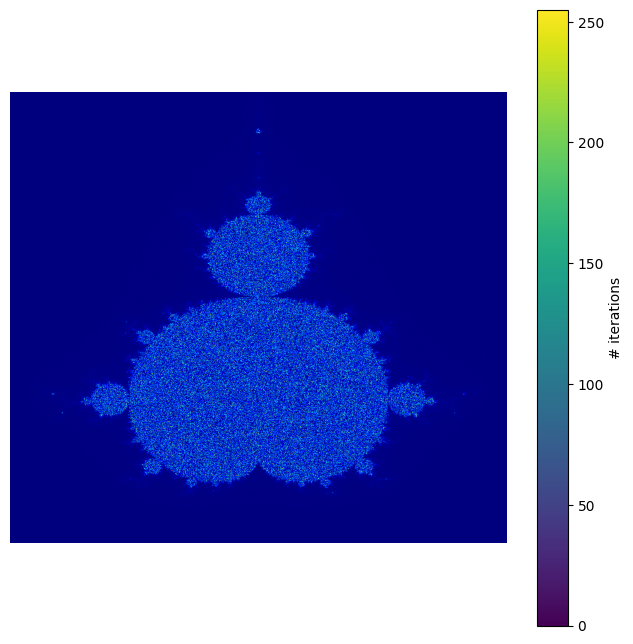

In [71]:
# Jonas
points_mc, counts_mc = mandelbrot_parallel_mc()
mandelbrot_statistics(points_mc, counts_mc, method='monte-carlo')
plot_mandelbrot_gradient(points_mc, counts_mc, method='monte-carlo')

Mandelbrot area: 1.51859125 using fixed method
Mean estimated area: 1.51859125e-06
Standard deviation of estimated area: 2.852052522899437e-06
95% Confidence interval for the estimated area: (1.5130013297731005e-06, 1.5241811702268994e-06)
Saved: media/mandelbrot_fixed_gradient_250_1000.png


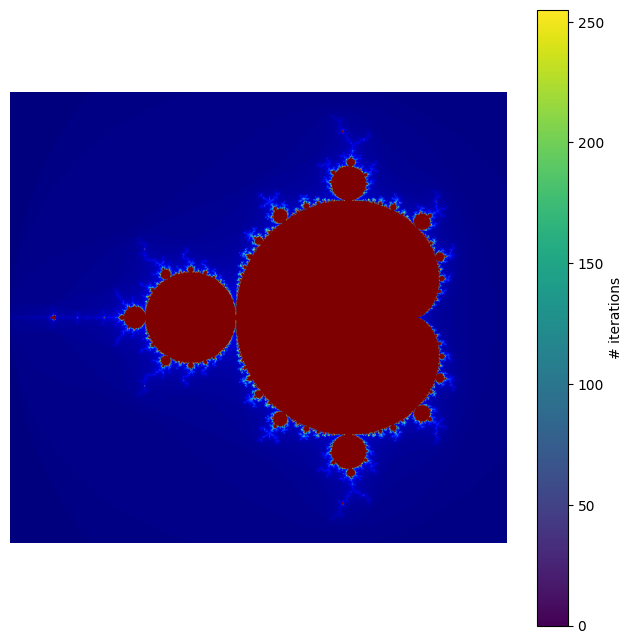

In [63]:
# Jonas
points_fixed, counts_fixed = mandelbrot_parallel_fixed()
mandelbrot_statistics(points_fixed, counts_fixed, method='fixed')
plot_mandelbrot_gradient(points_fixed, counts_fixed, method='fixed')

In [64]:
# Raymond
def latin_hypercube_sampling(max_iter, n_samples):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n_samples)
    range_real = X_LIM[1] - X_LIM[0]
    range_imag = Y_LIM[1] - Y_LIM[0]
    points = np.zeros((n_samples, 2))
    points[:, 0] = X_LIM[0] + sample[:, 0] * range_real
    points[:, 1] = Y_LIM[0] + sample[:, 1] * range_imag
    c_points = points[:, 0] + 1j * points[:, 1]
    counts = np.array([mandelbrot(c, max_iter) for c in c_points])
    return c_points, counts


In [65]:
# Raymond
@jit(nopython=True)
def stratified_sampling(max_iter, n_strata, samples_per_stratum):
    real_strata_edges = np.linspace(*X_LIM, n_strata + 1)
    imag_strata_edges = np.linspace(*Y_LIM, n_strata + 1)
    
    c_points = np.zeros(n_strata * n_strata * samples_per_stratum, dtype=np.complex128)
    counts = np.zeros(n_strata * n_strata * samples_per_stratum, dtype=np.int32)
    
    index = 0
    for i in prange(n_strata):
        for j in prange(n_strata):
            real_samples = np.random.uniform(real_strata_edges[i], real_strata_edges[i+1], samples_per_stratum)
            imag_samples = np.random.uniform(imag_strata_edges[j], imag_strata_edges[j+1], samples_per_stratum)
            
            for k in prange(samples_per_stratum):
                c = real_samples[k] + 1j * imag_samples[k]
                c_points[index] = c
                counts[index] = mandelbrot(c, max_iter)
                index += 1

    return c_points, counts

Mandelbrot area: 1.5354625000000002 using monte-carlo method
Mean estimated area: 1.5354625e-05
Standard deviation of estimated area: 2.8633444756105773e-05
95% Confidence interval for the estimated area: (1.5177156331823984e-05, 1.5532093668176012e-05)
Mandelbrot area: 1.5600172870383993 using monte-carlo method
Mean estimated area: 1.0432525626535765e-05
Standard deviation of estimated area: 1.9256490292357674e-05
95% Confidence interval for the estimated area: (1.0334924405551846e-05, 1.0530126847519685e-05)
Mandelbrot area: 1.5574716241961306 using monte-carlo method
Mean estimated area: 6.965249699006873e-06
Standard deviation of estimated area: 1.2870117084633708e-05
95% Confidence interval for the estimated area: (6.911905295589363e-06, 7.018594102424382e-06)
Mandelbrot area: 1.5477128629960821 using monte-carlo method
Mean estimated area: 4.628743197643576e-06
Standard deviation of estimated area: 8.58759576256674e-06
95% Confidence interval for the estimated area: (4.599635622

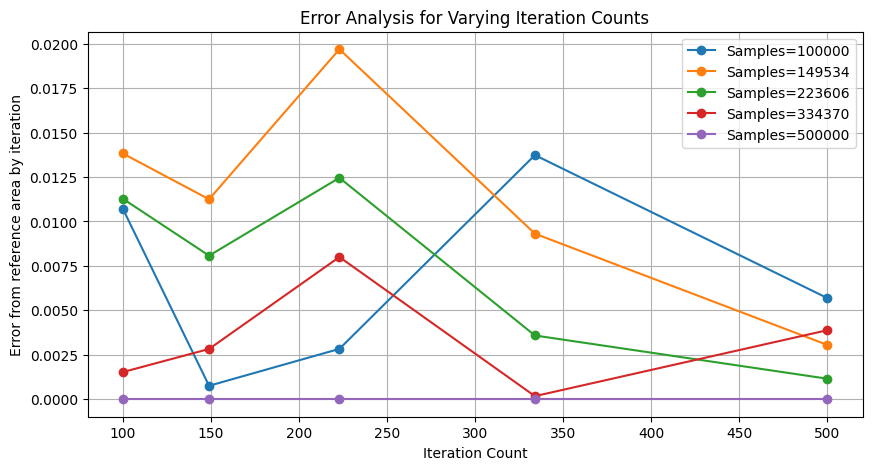

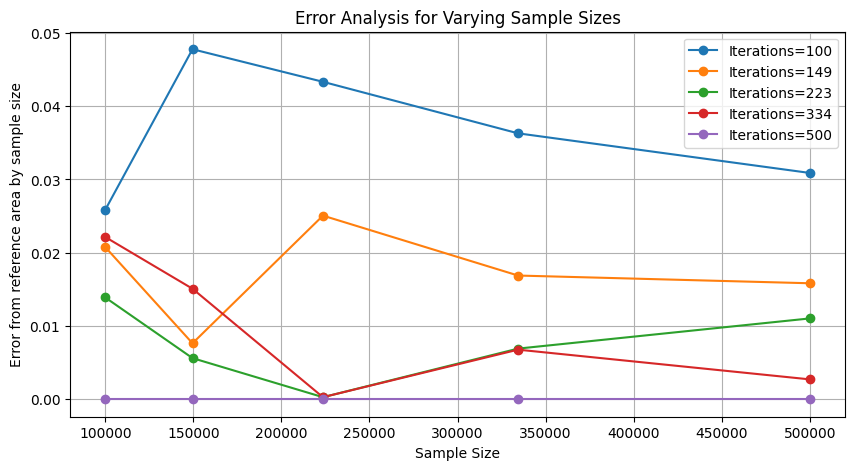

In [66]:
# Raymond
import pandas as pd

def investigate_convergence(iter_range, sample_sizes, improvement_method=None):
    results_list = []

    for max_iter in iter_range:
        for n_samples in sample_sizes:
            if n_samples >= max_iter:  # Balance i and s
                if improvement_method == 'lhs':
                    c_points, counts = latin_hypercube_sampling(max_iter, n_samples)
                elif improvement_method == 'stratified':
                    n_strata = int(np.sqrt(n_samples))  # Assuming square root of n_samples as number of strata
                    samples_per_stratum = n_samples // n_strata
                    c_points, counts = stratified_sampling(max_iter, n_strata, samples_per_stratum)
                else:
                    c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)

                stats = mandelbrot_statistics(c_points, counts, method=improvement_method or 'monte-carlo')
                results_list.append({
                    'iterations': max_iter,
                    'samples': n_samples,
                    'estimated_area': stats['area'],
                    'std_dev': stats['std'],
                    'conf_int_low': stats['conf_int'][0],
                    'conf_int_high': stats['conf_int'][1]
                })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results_list)

    # Plot the error as a function of iteration count j for the largest iteration i
    largest_i = max(iter_range)
    # Initialize reference areas for comparison
    reference_area_by_iter = results_df[results_df['samples'] == max(sample_sizes)].set_index('iterations')['estimated_area']
    reference_area_by_samples = results_df[results_df['iterations'] == max(iter_range)].set_index('samples')['estimated_area']

    # Error as a function of iteration count
    plt.figure(figsize=(10, 5))
    for sample_size in sample_sizes:
        errors = []
        for iter_count in iter_range:
            if not results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)].empty:
                estimated_area = results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)]['estimated_area'].iloc[0]
                ref_area = reference_area_by_iter[iter_count]
                error = abs(estimated_area - ref_area)
                errors.append(error)
        plt.plot(iter_range, errors, '-o', label=f'Samples={sample_size}')
    plt.xlabel('Iteration Count')
    plt.ylabel('Error from reference area by iteration')
    plt.legend()
    plt.title('Error Analysis for Varying Iteration Counts')
    plt.grid(True)
    plt.show()

    # Compute and plot errors
    # reference_area = results_df[results_df['iterations'] == max(iter_range)]['estimated_area'].iloc[0]
    plt.figure(figsize=(10, 5))
    for iter_count in iter_range:
        errors = []
        for sample_size in sample_sizes:
            if not results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)].empty:
                estimated_area = results_df[(results_df['iterations'] == iter_count) & (results_df['samples'] == sample_size)]['estimated_area'].iloc[0]
                ref_area = reference_area_by_samples[sample_size]
                error = abs(estimated_area - ref_area)
                errors.append(error)
        plt.plot(sample_sizes, errors, '-o', label=f'Iterations={iter_count}')
    plt.xlabel('Sample Size')
    plt.ylabel('Error from reference area by sample size')
    plt.legend()
    plt.title('Error Analysis for Varying Sample Sizes')
    plt.grid(True)
    plt.show()

    return results_df


iter_range = np.geomspace(100, 500, num=5).astype(int)  # Iteration range
sample_sizes = np.geomspace(100000, 500000, num=5).astype(int)  # Sample size range
results_df = investigate_convergence(iter_range, sample_sizes)

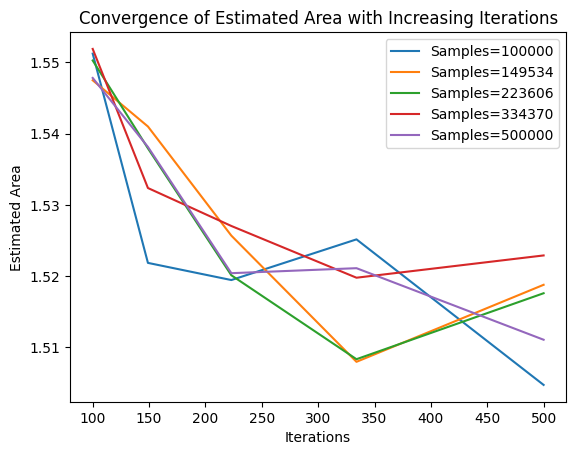

In [67]:
# Plot the estimated area as a function of iterations for each sample size Raymond
for samples in sample_sizes:
    subset = data[data['samples'] == samples]
    plt.plot(subset['iterations'], subset['estimated_area'], label=f'Samples={samples}')

plt.xlabel('Iterations')
plt.ylabel('Estimated Area')
plt.legend()
plt.title('Convergence of Estimated Area with Increasing Iterations')
plt.show()

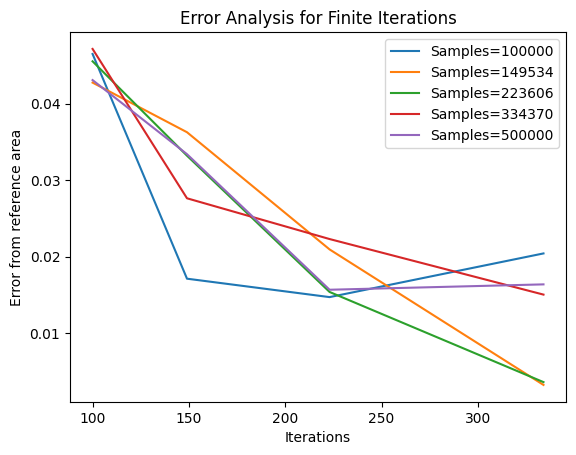

In [68]:
# Plot the error as a function of iteration count j for the largest iteration i Raymond
largest_i = max(iter_range)
reference_area = data[data['iterations'] == largest_i]['estimated_area'].iloc[0]

for samples in sample_sizes:
    errors = []
    for i in iter_range:
        if i < largest_i:
            current_area = data[(data['iterations'] == i) & (data['samples'] == samples)]['estimated_area'].iloc[0]
            error = abs(current_area - reference_area)
            errors.append(error)
    plt.plot(iter_range[:-1], errors, label=f'Samples={samples}')

plt.xlabel('Iterations')
plt.ylabel('Error from reference area')
plt.legend()
plt.title('Error Analysis for Finite Iterations')
plt.show()

Mandelbrot area: 1.5465979475634788 using stratified method
Mean estimated area: 4.9013552539818386e-08
Standard deviation of estimated area: 9.097581759043466e-08
95% Confidence interval for the estimated area: (4.898180987126793e-08, 4.904529520836884e-08)
Mandelbrot area: 1.546456775403436 using stratified method
Mean estimated area: 2.6819594751159344e-08
Standard deviation of estimated area: 4.978374560926389e-08
95% Confidence interval for the estimated area: (2.680674505458455e-08, 2.6832444447734136e-08)
Mandelbrot area: 1.546527703546829 using stratified method
Mean estimated area: 1.467616433512498e-08
Standard deviation of estimated area: 2.7241754335934466e-08
95% Confidence interval for the estimated area: (1.4670963050807974e-08, 1.4681365619441987e-08)
Mandelbrot area: 1.546487095878421 using stratified method
Mean estimated area: 8.008714008638964e-09
Standard deviation of estimated area: 1.486594929105514e-08
95% Confidence interval for the estimated area: (8.006617247

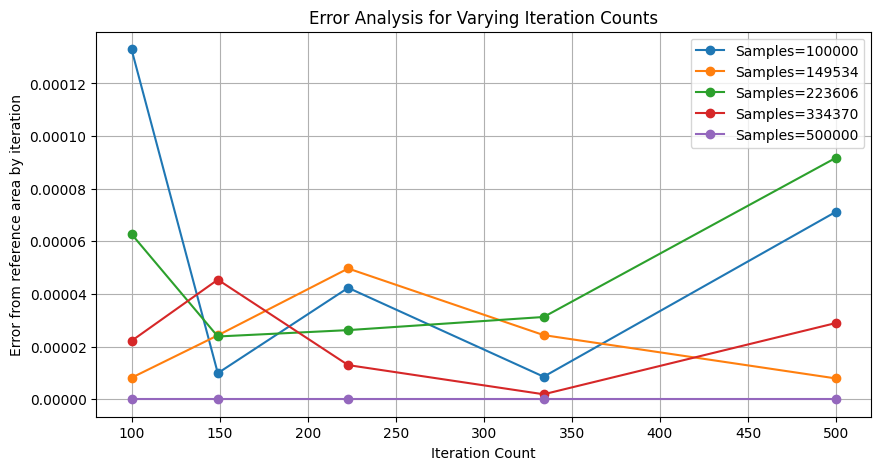

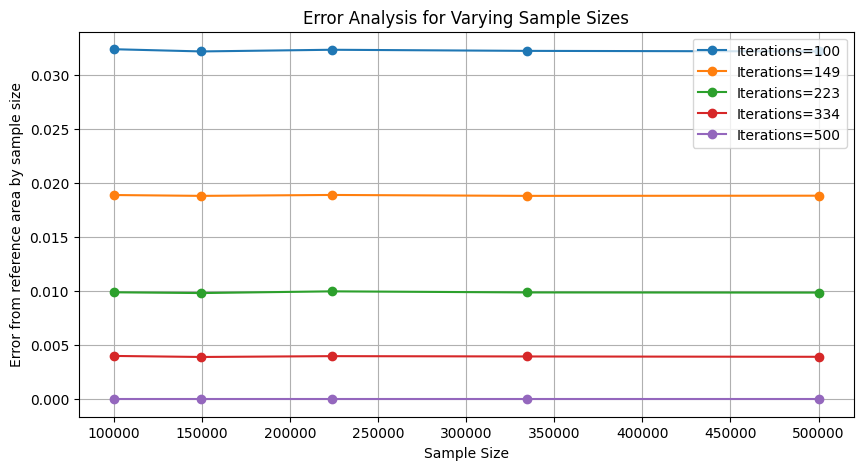

In [69]:
# Raymond
results_df = investigate_convergence(iter_range, sample_sizes, improvement_method='stratified')

Mandelbrot area: 1.5518937499999998 using random method
Mean estimated area: 1.5518937499999997e-05
Standard deviation of estimated area: 2.874191700242041e-05
95% Confidence interval for the estimated area: (1.5340796526229894e-05, 1.56970784737701e-05)
Mandelbrot area: 1.5539944092982199 using random method
Mean estimated area: 1.0392247979043026e-05
Standard deviation of estimated area: 1.9230168295934288e-05
95% Confidence interval for the estimated area: (1.0294780170687817e-05, 1.0489715787398235e-05)
Mandelbrot area: 1.5462185719524522 using random method
Mean estimated area: 6.914924339921342e-06
Standard deviation of estimated area: 1.2837099711188632e-05
95% Confidence interval for the estimated area: (6.8617167877909855e-06, 6.968131892051699e-06)
Mandelbrot area: 1.5479595956575052 using random method
Mean estimated area: 4.629481100749185e-06
Standard deviation of estimated area: 8.588081357332516e-06
95% Confidence interval for the estimated area: (4.600371879408448e-06, 

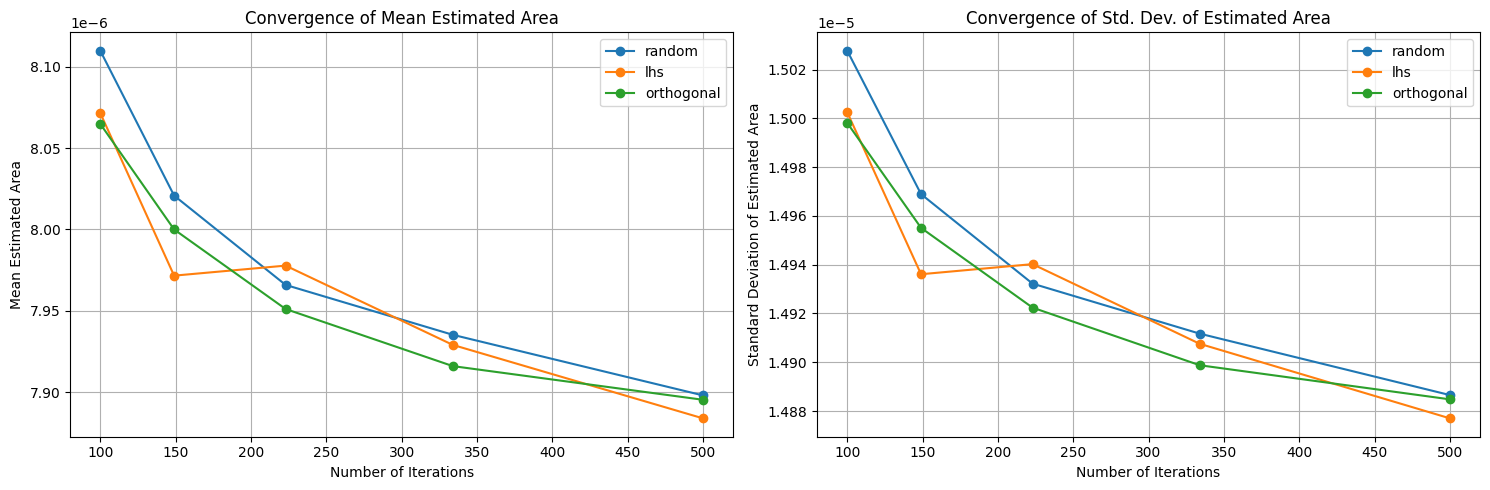

In [70]:
# Raymond
from pyDOE import lhs


def orthogonal_sampling(max_iter, n_samples, d=2):
    # Using Latin Hypercube Sampling as a basis for orthogonal sampling
    intervals = np.linspace(0, 1, int(np.sqrt(n_samples)) + 1)
    points = np.array(np.meshgrid(*([intervals]*d))).T.reshape(-1, d)
    np.random.shuffle(points)
    points = points[:n_samples]
    
    range_real = X_LIM[1] - X_LIM[0]
    range_imag = Y_LIM[1] - Y_LIM[0]
    sampled_points = np.zeros((n_samples, 2))
    sampled_points[:, 0] = X_LIM[0] + points[:, 0] * range_real
    sampled_points[:, 1] = Y_LIM[0] + points[:, 1] * range_imag
    c_points = sampled_points[:, 0] + 1j * sampled_points[:, 1]
    counts = np.array([mandelbrot(c, max_iter) for c in c_points])
    return c_points, counts

def antithetic_variates(c_points, counts, max_iter):
    antithetic_points = -c_points  # This is a simplification, you'll need to adapt it based on your function domain
    antithetic_counts = np.array([mandelbrot(c, max_iter) for c in antithetic_points])
    return (counts + antithetic_counts) / 2  # Take the average of normal and antithetic counts

def run_simulation(max_iter, n_samples, sampling_method):
    stats_list = []
    for _ in range(10):  # Example: run 10 simulations and collect statistics
        if sampling_method == 'random':
            c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)
            counts = antithetic_variates(c_points, counts, max_iter)  # Use antithetic variates
        elif sampling_method == 'lhs':
            c_points, counts = latin_hypercube_sampling(max_iter, n_samples)
        elif sampling_method == 'orthogonal':
            c_points, counts = orthogonal_sampling(max_iter, n_samples)
        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")
        stats_list.append(mandelbrot_statistics(c_points, counts, sampling_method))
    return stats_list

def control_variates(counts, known_mean):
    control_variate = known_mean  # You need to determine a suitable control variate
    adjusted_counts = counts + (known_mean - np.mean(counts))  # Adjust the counts
    return adjusted_counts

def importance_sampling(max_iter, n_samples, target_distribution, importance_distribution):
    samples = importance_distribution.rvs(n_samples)
    weights = target_distribution.pdf(samples) / importance_distribution.pdf(samples)
    weighted_counts = np.array([mandelbrot(samples[i], max_iter) * weights[i] for i in range(n_samples)])
    return weighted_counts

def investigate_convergence(iter_range, sample_sizes, methods):
    # This will store the mean of the estimated area for each method
    mean_estimated_areas = {method: [] for method in methods}
    # This will store the standard deviation of the estimated area for each method
    std_dev_estimated_areas = {method: [] for method in methods}
    
    for max_iter in iter_range:
        for method in methods:
            mean_area_for_iter = []
            std_dev_for_iter = []

            for n_samples in sample_sizes:
                # Run your simulations here and collect the stats
                if method == 'random':
                    c_points, counts = mandelbrot_parallel_mc(max_iter, n_samples)
                elif method == 'lhs':
                    c_points, counts = latin_hypercube_sampling(max_iter, n_samples)
                elif method == 'orthogonal':
                    c_points, counts = orthogonal_sampling(max_iter, n_samples)
                
                # Get statistics
                stats = mandelbrot_statistics(c_points, counts, method)

                # Store the mean and std_dev for this number of samples
                mean_area_for_iter.append(stats['mean'])
                std_dev_for_iter.append(stats['std'])

            # Store the average of the mean area and std_dev for this iteration count
            mean_estimated_areas[method].append(np.mean(mean_area_for_iter))
            std_dev_estimated_areas[method].append(np.mean(std_dev_for_iter))

    return mean_estimated_areas, std_dev_estimated_areas

# Run the convergence investigation
mean_areas, std_dev_areas = investigate_convergence(iter_range, sample_sizes, methods)

# Now let's plot the results
plt.figure(figsize=(15, 5))

# Plotting mean estimated area
plt.subplot(1, 2, 1)
for method in methods:
    plt.plot(iter_range, mean_areas[method], '-o', label=method)
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Estimated Area')
plt.title('Convergence of Mean Estimated Area')
plt.legend()
plt.grid(True)

# Plotting standard deviation of estimated area
plt.subplot(1, 2, 2)
for method in methods:
    plt.plot(iter_range, std_dev_areas[method], '-o', label=method)
plt.xlabel('Number of Iterations')
plt.ylabel('Standard Deviation of Estimated Area')
plt.title('Convergence of Std. Dev. of Estimated Area')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()